In [42]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from surprise import *
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from collections import defaultdict

In [43]:
# import dataset
data = pd.read_csv("data/up-selling/peotv/peoTV_user_ratings.csv")
try:
    data.drop(["Unnamed: 0"],axis=1,inplace=True)
except:
    pass
data_pca = data[["ACCOUNT_NUM.hash","package","pca_ratings"]].rename(columns={"pca_ratings":"ratings"})
data_pca.dropna(subset=["ratings"],inplace=True)
data = data[["ACCOUNT_NUM.hash","package","ratings"]]

In [ ]:
data.info()

In [ ]:
data_pca.info()

## Interaction Matrix

In [ ]:
# create a histogram of all the interactions by all the users present in the dataset
def create_interaction_matrix(data):
    interactions = data.groupby('ACCOUNT_NUM.hash').count()['package']
    plt.hist(interactions,bins=20)
    plt.show()

    # create the user item matrix using the ratings dataset - Hint: try using pivot function 
    interactions_metrix = data.pivot_table(index="ACCOUNT_NUM.hash", columns="package", values="ratings",aggfunc=np.sum)
    # replace all the missing values with zero
    return interactions_metrix.fillna(0)

In [ ]:
create_interaction_matrix(data)

In [ ]:
create_interaction_matrix(data_pca)

## Function Definition

In [ ]:
def train_test_splitter(data):
    reader = Reader(rating_scale=(0, 1))
    data_model = Dataset.load_from_df(data, reader)
    return data_model,train_test_split(data_model, test_size=.20)

In [ ]:
def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0


In [ ]:
def get_top_n(predictions, n=10):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:5]
        

    return top_n

In [ ]:
# calculate NDCG
def ndcg(y_true, y_pred, k=None, powered=False):
    def dcg(scores, k=None, powered=False):
        if k is None:
            k = scores.shape[0]
        if not powered:
            ret = scores[0]
            for i in range(1, k):
                ret += scores[i] / np.log2(i + 1)
            return ret
        else:
            ret = 0
            for i in range(k):
                ret += (2 ** scores[i] - 1) / np.log2(i + 2)
            return ret
    
    ideal_sorted_scores = np.sort(y_true)[::-1]
    ideal_dcg_score = dcg(ideal_sorted_scores, k=k, powered=powered)
    
    pred_sorted_ind = np.argsort(y_pred)[::-1]
    pred_sorted_scores = y_true[pred_sorted_ind]
    dcg_score = dcg(pred_sorted_scores, k=k, powered=powered)
    
    return dcg_score / ideal_dcg_score

def ndcg1(y_true, y_pred, k=None):
    return ndcg(y_true, y_pred, k=k, powered=False)

def ndcg2(y_true, y_pred, k=None):
    return ndcg(y_true, y_pred, k=k, powered=True)

In [ ]:
def top_n_pred(predictions):
    top_n = get_top_n(predictions, n=3)
    #print(top_n)
    users_est = defaultdict(list)
    users_true=defaultdict(list)
    rec_for_user=defaultdict(list)
    for uid, user_ratings in top_n.items():
        users_est[uid].append([est for (_, est,_) in user_ratings])
        users_true[uid].append([true_r for (_,_,true_r) in user_ratings])
        rec_for_user[uid].append([iid for (iid,_,_) in user_ratings])
    return top_n, users_est, users_true, rec_for_user

In [13]:
def calc_ndcg(users_true,users_est):
    ndcg_list=[]
    for uid in top_n:
        
        for i in users_true[uid]:
            y_true=np.asarray(i)#.reshape(-1,1)
        for i in users_est[uid]:
            y_pred=np.asarray(i)#.reshape(-1,1)
        
            ndcg_list.append(ndcg1(y_true, y_pred, k=None))

    ndcg_list = [i for i in ndcg_list if str(i) != 'nan']
    ndgc_rate = np.mean(ndcg_list)
    return ndcg_list, ndgc_rate

## Collabarative Recomenders with Surprise

In [14]:
data_model, (trainset, testset) = train_test_splitter(data)
data_model_pca, (trainset_pca, testset_pca) = train_test_splitter(data_pca)

### SVD recommender

In [15]:
# We'll use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results
svd_validate = cross_validate(algo, data_model_pca, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2706  0.2685  0.2697  0.2703  0.2682  0.2695  0.0010  
MAE (testset)     0.2217  0.2193  0.2193  0.2194  0.2185  0.2196  0.0011  
Fit time          7.04    6.46    6.56    6.75    6.51    6.66    0.21    
Test time         0.23    0.39    0.21    0.40    0.21    0.29    0.09    


In [16]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset_pca)
predictions = algo.test(testset_pca)

Top-N predictions

In [17]:
top_n, users_est, users_true, rec_for_user = top_n_pred(predictions)

NDCG

In [18]:
ndcg_list, ndgc_rate = calc_ndcg(users_true,users_est)
print("NDCG", ndgc_rate)

NDCG 0.9788767575680651


In [19]:
# dataframe with all the predictions
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [20]:
# 10 Best predictions
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
6387,00df56a4981dab339e1b6fdfa0ab1281,PEO_UNNATHAM,0.448078,0.448056,{'was_impossible': False},6,2983,0.000022
9506,78278cd62ed300744488ab89bca58287,PEO_ENTERTAINMENT_FTTH,0.448078,0.448113,{'was_impossible': False},8,1073,0.000035
23564,a41adce43d234428f5add63b35d40d91,PEO_SILVER,0.475674,0.475713,{'was_impossible': False},7,82776,0.000039
833,a41adce43d234428f5add63b35d40d91,PEO_SILVER,0.475674,0.475713,{'was_impossible': False},7,82776,0.000039
9972,4426e9b478a0f8b1054478f7b868789a,PEO_SILVER,0.420482,0.420435,{'was_impossible': False},6,82776,0.000047
600,4e3d37fdbbe6174ef9d9935a06a738fa,PEO_SILVER,0.392886,0.392949,{'was_impossible': False},7,82776,0.000063
31408,edf3db27098a385aae823c8d630f607e,PEO_SILVER,0.392886,0.392818,{'was_impossible': False},8,82776,0.000068
24098,c38be2aff5690b20a6aa3fa3144c5de8,PEO_UNNATHAM,0.530866,0.530793,{'was_impossible': False},8,2983,0.000074
5353,c38be2aff5690b20a6aa3fa3144c5de8,PEO_UNNATHAM,0.530866,0.530793,{'was_impossible': False},8,2983,0.000074
16510,d6449c1b4908fd8e1d459d716644c106,PEO_SILVER_FTTH,0.365218,0.365142,{'was_impossible': False},3,16940,0.000075


In [21]:
rmse = accuracy.rmse(predictions)
print("RMSE -->",rmse)
print("Accuracy -->",1-rmse)

RMSE: 0.2704
RMSE --> 0.2704420117948464
Accuracy --> 0.7295579882051536


### SlopeOne recommender

In [22]:
# We'll use the SlopeOne algorithm.
algo = SlopeOne()

# Run 5-fold cross-validation and print results
so_validate =cross_validate(algo, data_model_pca, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2749  0.2747  0.2765  0.2763  0.2751  0.2755  0.0008  
MAE (testset)     0.2153  0.2157  0.2168  0.2167  0.2158  0.2160  0.0006  
Fit time          0.23    0.26    0.28    0.27    0.27    0.26    0.02    
Test time         0.38    0.38    0.39    0.58    0.38    0.42    0.08    


In [23]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset_pca)
predictions = algo.test(testset_pca)

Top N predictions

In [24]:
top_n, users_est, users_true, rec_for_user = top_n_pred(predictions)

NDCG

In [25]:
ndcg_list, ndgc_rate = calc_ndcg(users_true,users_est)
print("NDCG", ndgc_rate)

NDCG 0.9789006224152145


In [26]:
# dataframe with all the predictions
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [27]:
# 10 Best predictions
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
17926,0fb6934dbb31b60c61e5c13f827a495b,PRANAMA,1.000000,1.000000,{'was_impossible': False},9,4064,0.0
30223,c164df7a5079f4e0186c2f8591cc914a,PEO_UTHAYAM,0.503270,0.503270,{'was_impossible': False},1,17814,0.0
3339,7ffa7e07ae230f19be9a9086ef604314,PEO_SILVER,0.889471,0.889471,{'was_impossible': False},1,82776,0.0
16813,450589c449837400fc8ca35a9f7e5a0f,PEO_UNNATHAM,0.944804,0.944804,{'was_impossible': False},2,2983,0.0
16905,654440f1ce99171aa91c960d4458f8d1,PEO_SILVER,0.172117,0.172117,{'was_impossible': False},3,82776,0.0
30177,e60a618d0b99e0b3b8fc77bbf9c6c3cb,PEO_SILVER,0.061733,0.061733,{'was_impossible': False},6,82776,0.0
22888,b701180904910d948e97ec47a0d50553,PEO_SILVER,1.000000,1.000000,{'was_impossible': False},7,82776,0.0
16928,31db095dc413c41f3ac6f7a9403b6537,PEO_SILVER,1.000000,1.000000,{'was_impossible': False},6,82776,0.0
227,acfdf14a899a6a642ad6bacb81f8e686,PEO_SILVER,0.172117,0.172117,{'was_impossible': False},1,82776,0.0
4893,db1c82e1626a0f80f72ad5e3904a13e1,PEO_SILVER,1.000000,1.000000,{'was_impossible': False},9,82776,0.0


In [28]:
rmse = accuracy.rmse(predictions)
print("RMSE -->",rmse)
print("Accuracy -->",1-rmse)

RMSE: 0.2762
RMSE --> 0.2761700756201991
Accuracy --> 0.723829924379801


## Baseline Only

In [35]:
# We'll use the SlopeOne algorithm.
algo = BaselineOnly()

# Run 5-fold cross-validation and print results
bo_validate =cross_validate(algo, data_model_pca, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2726  0.2739  0.2738  0.2719  0.2732  0.2731  0.0007  
MAE (testset)     0.2249  0.2258  0.2257  0.2235  0.2248  0.2249  0.0008  
Fit time          0.26    0.27    0.30    0.27    0.29    0.28    0.02    
Test time         0.15    0.16    0.15    0.40    0.15    0.20    0.10    


In [36]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset_pca)
predictions = algo.test(testset_pca)

Estimating biases using als...


Top n recommendations

In [37]:
top_n, users_est, users_true, rec_for_user = top_n_pred(predictions)

NDCG

In [38]:
ndcg_list, ndgc_rate = calc_ndcg(users_true,users_est)
print("NDCG", ndgc_rate)

NDCG 0.9789158974061646


In [39]:
# dataframe with all the predictions
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [40]:
# 10 Best predictions
best_predictions = df.sort_values(by='err')[:10]
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
24065,3a4d526629bf5487d1596c6c927944e3,PEO_UTHAYAM,0.503270,0.503286,{'was_impossible': False},6,17814,0.000016
15947,6c032e501b4880eaa8e71b23ef373377,PEO_SILVER,0.392884,0.392906,{'was_impossible': False},8,82776,0.000022
6963,9ddcb6d04ab42e2a2ce798f780d69af7,PEO_UTHAYAM,0.448077,0.448035,{'was_impossible': False},8,17814,0.000042
6521,14dfadad5bbbb803a6dc9f784ffe9f8f,PEO_UTHAYAM,0.448078,0.448016,{'was_impossible': False},8,17814,0.000062
29389,0426a9264ab054a36f67568b4a20db71,PEO_RELIGIOUS_PACKAGE,0.503270,0.503193,{'was_impossible': False},6,212,0.000077
11942,317a5fd1ef0687a79a681cecbccedde0,PEO_SILVER,0.503270,0.503192,{'was_impossible': False},9,82776,0.000078
10976,fa9b83063a2126c33a9e2a2d46688761,PEO_SILVER_PLUS,0.503270,0.503189,{'was_impossible': False},6,5458,0.000081
28755,767cb6cdadc6ddfe1bed0b035994123c,PEO_SILVER_PLUS,0.420482,0.420384,{'was_impossible': False},7,5458,0.000097
6034,0b790cb2dc8d06c1e50016b09c82558c,PEO_TITANIUM_FTTH,0.475671,0.475496,{'was_impossible': False},9,1414,0.000175
21480,38114da7be92eb96b5b0a6fbfa128624,NEW_SLT_STAFF_PACKAGE,0.392886,0.392672,{'was_impossible': False},5,753,0.000214


In [41]:
rmse = accuracy.rmse(predictions)
print("RMSE -->",rmse)
print("Accuracy -->",1-rmse)

RMSE: 0.2743
RMSE --> 0.27432531380262376
Accuracy --> 0.7256746861973762


### Benchmark algorithms

In [29]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SlopeOne(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_model_pca, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
val_df = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
val_df

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.269384,6.449129,0.293777
BaselineOnly,0.273062,0.236808,0.238699
SlopeOne,0.275923,0.262995,0.416275
CoClustering,0.449263,3.505755,0.206416


## CF Recommenders Accuracy Plots

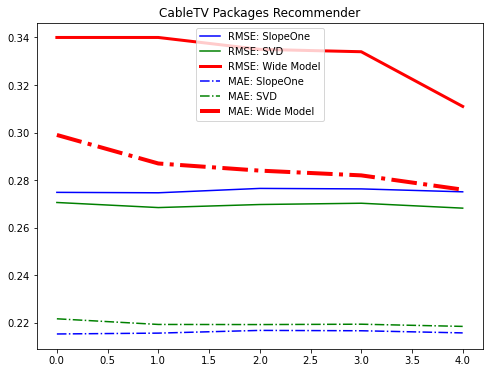

In [33]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(so_validate["test_rmse"], color='blue')
ax.plot(svd_validate["test_rmse"], color='green')
ax.plot(bo_validate["test_rmse"], color='orange')
ax.plot([0.340,0.340,0.335,0.334,0.311],linewidth=3, color='red')
ax.plot(so_validate["test_mae"], linestyle='dashdot', color='blue')
ax.plot(svd_validate["test_mae"], linestyle='dashdot', color='green')
ax.plot(bo_validate["test_mae"], linestyle='dashdot', color='orange')
ax.plot([0.299,0.287,0.284,0.282,0.276],linewidth=4, linestyle='dashdot', color='red')
# plt.xticks(np.arange(0, 30, 0.5))
plt.title("CableTV Packages Recommender", loc="center")
plt.legend(["RMSE: SlopeOne","RMSE: SVD","RMSE: BaselineOnly","RMSE: Wide Model",
           "MAE: SlopeOne","MAE: SVD","MAE: BaselineOnly","MAE: Wide Model"])

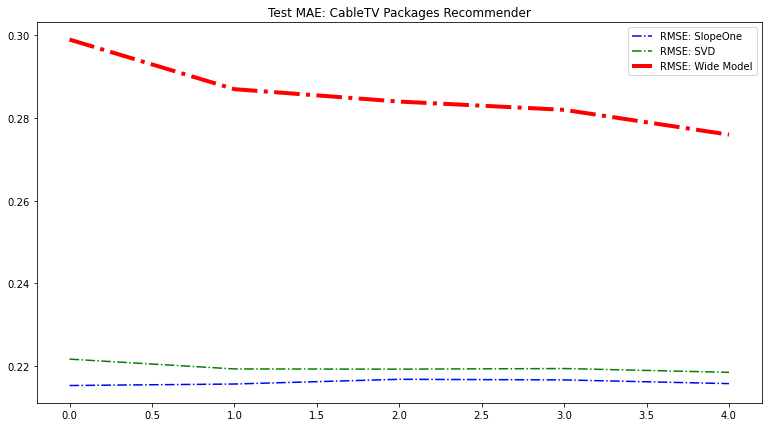

In [34]:
fig,ax = plt.subplots(figsize=(13,7))
ax.plot(so_validate["test_mae"], linestyle='dashdot', color='blue')
ax.plot(svd_validate["test_mae"], linestyle='dashdot', color='green')
ax.plot(bo_validate["test_mae"], linestyle='dashdot', color='green')
ax.plot([0.299,0.287,0.284,0.282,0.276],linewidth=4, linestyle='dashdot', color='red')
# plt.xticks(np.arange(0, 4, 0.2))
plt.title("Test MAE: CableTV Packages Recommender", loc="center")
plt.legend(["MAE: SlopeOne","MAE: SVD","MAE: BaselineOnly","MAE: Wide Model"])

# Ensamble Recommender Model